# Tutorial 4: Stacking Sats Challenge

### Strategy Development Template

**Hosted on [Hypertrial.ai](https://www.hypertrial.ai/)**

---

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hypertrial/stacking_sats_challenge/blob/main/tutorials/4.%20Strategy%20Development%20Template.ipynb)

[![YouTube](https://img.shields.io/badge/Watch%20on-YouTube-red?logo=youtube&logoColor=white)](https://youtu.be/qJp8W83f3Fw?si=Wzo8ORKwFLHhBoM0)

Welcome to the official submission template for the Stacking Sats Challenge.  
This notebook replicates the structure used by the evaluation engine to test all participant strategies.

---

## ✅ What You’ll Learn

By the end of this tutorial, you will:

- Understand the **boilerplate code** and what is already provided (e.g. imports, data loading, global config)
- Learn where and how to **insert your own strategy logic**
- Run **backtests and visualizations** to debug and assess performance
- Ensure your submission is **valid, testable, and reproducible**

---

## 🛠️ What You’re Expected to Do

- **Modify only the strategy function** inside the provided cell  
- Leave all boilerplate (e.g. registration, config, data loading) unchanged
- Submit your **dynamic_rule_causal** function for evaluation on [Hypertrial.ai]('https://www.hypertrial.ai/')

This structure guarantees consistency, fairness, and ease of comparison across all submitted models.

---

> ⚠️ Do not change function names, decorators, or global config values unless explicitly allowed.  
> Your entry must adhere to this template to be considered valid.


### 🚫 Boilerplate Code — Do Not Modify

import subprocess
import sys
import importlib
from packaging import version
import pkg_resources

REQUIRED_PACKAGES = {
    "pandas": "2.0.0",
    "numpy": "2.0.0",  # We will downgrade this manually if ≥ 2.x is installed
    "matplotlib": "3.7.0",
    "coinmetrics-api-client": "2024.2.6.16",
    "pytest": "8.0.0",
    "scipy": "1.10.0",
    "psutil": "6.0.0",
    "bandit": "1.7.0",
    "safety": "3.0.0",
    "pylint": "3.0.0",
    "pytest-cov": "4.1.0",
}


def install_package(package: str, min_version: str):
    try:
        subprocess.check_call([
            sys.executable, "-m", "pip", "install", f"{package}>={min_version}"
        ])
    except subprocess.CalledProcessError as e:
        print(f"❌ Failed to install {package}: {e}")


def force_downgrade_numpy():
    print("⚠️  NumPy 2.x detected, which may break compiled packages.")
    print("🔁 Downgrading to numpy<2.0.0 to ensure compatibility...")
    try:
        subprocess.check_call([
            sys.executable, "-m", "pip", "install", "numpy<2.0.0"
        ])
        print("✅ Successfully downgraded NumPy to <2.0.0")
    except subprocess.CalledProcessError as e:
        print(f"❌ Failed to downgrade NumPy: {e}")


def get_installed_version(package: str) -> str:
    try:
        return pkg_resources.get_distribution(package).version
    except Exception:
        try:
            mod = importlib.import_module(package.replace("-", "_"))
            return getattr(mod, "__version__", "0.0.0")
        except Exception:
            return "0.0.0"


def is_outdated(installed: str, required: str) -> bool:
    return version.parse(installed) < version.parse(required)


def setup_environment():
    print("🔧 Setting up your environment...\n")

    # Special check for NumPy version >= 2.0.0
    numpy_version = get_installed_version("numpy")
    if version.parse(numpy_version) >= version.parse("2.0.0"):
        force_downgrade_numpy()
        return  # Restart recommended after downgrade

    for pkg, min_ver in REQUIRED_PACKAGES.items():
        if pkg == "numpy":  # Already handled above
            continue
        installed_ver = get_installed_version(pkg)
        if is_outdated(installed_ver, min_ver):
            print(f"⬇️  Installing/upgrading {pkg}: found v{installed_ver}, requires ≥ v{min_ver}")
            install_package(pkg, min_ver)
        else:
            print(f"✅ {pkg} is up to date (v{installed_ver})")


if __name__ == "__main__":
    setup_environment()

In [4]:
# 🚫 DO NOT MODIFY: Framework boilerplate cell
# ---------------------------
# core/config.py
# ---------------------------
BACKTEST_START = '2013-01-01'
BACKTEST_END = '2024-12-31'
CYCLE_YEARS = 4

MIN_WEIGHT = 1e-5 

In [5]:
# 🚫 DO NOT MODIFY: Framework boilerplate cell
# ---------------------------
# Extract BTC data from CoinMetrics and save locally
# ---------------------------
import pandas as pd 
import logging
from datetime import datetime

try:
    from coinmetrics.api_client import CoinMetricsClient
except ImportError:
    raise ImportError("coinmetrics.api_client module is required. Install it via pip:\n\n    pip install coinmetrics-api-client")

# Configure logging
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S'
)

def extract_btc_data_to_csv(local_path='btc_price_data.csv'):
    client = CoinMetricsClient()
    asset = 'btc'
    metric = 'PriceUSD'
    start_time = '2010-01-01'
    end_time = datetime.today().strftime('%Y-%m-%d')
    frequency = '1d'

    logging.info(f"Fetching BTC data from {start_time} to {end_time}...")

    btc_df = client.get_asset_metrics(
        assets=asset,
        metrics=[metric],
        frequency=frequency,
        start_time=start_time,
        end_time=end_time
    ).to_dataframe()

    btc_df = btc_df.rename(columns={metric: 'Close'})
    btc_df['time'] = pd.to_datetime(btc_df['time']).dt.normalize()
    btc_df['time'] = btc_df['time'].dt.tz_localize(None)
    btc_df.set_index('time', inplace=True)
    btc_df = btc_df[['Close']]
    btc_df = btc_df.rename(columns={"Close": "btc_close"})

    btc_df.to_csv(local_path)
    logging.info(f"Saved BTC data to {local_path}")
    logging.info(f"Total records: {len(btc_df)}")
    logging.info(f"Date range: {btc_df.index.min()} to {btc_df.index.max()}")

    return btc_df

btc_df = extract_btc_data_to_csv("btc_price_data.csv")

2025-05-06 17:44:20 INFO     Fetching BTC data from 2010-01-01 to 2025-05-06...
2025-05-06 17:44:22 INFO     Sleeping for a rate limit window because 429 (too many requests) error was returned. Please see Coin Metrics APIV4 documentation for more information: https://docs.coinmetrics.io/api/v4/#tag/Rate-limits
2025-05-06 17:44:29 INFO     Sleeping for a rate limit window because 429 (too many requests) error was returned. Please see Coin Metrics APIV4 documentation for more information: https://docs.coinmetrics.io/api/v4/#tag/Rate-limits
2025-05-06 17:44:37 INFO     Sleeping for a rate limit window because 429 (too many requests) error was returned. Please see Coin Metrics APIV4 documentation for more information: https://docs.coinmetrics.io/api/v4/#tag/Rate-limits
2025-05-06 17:44:44 INFO     Sleeping for a rate limit window because 429 (too many requests) error was returned. Please see Coin Metrics APIV4 documentation for more information: https://docs.coinmetrics.io/api/v4/#tag/Rate

In [6]:
# 🚫 DO NOT MODIFY: Framework boilerplate cell
# ---------------------------
# core/data.py
# ---------------------------
import pandas as pd
import numpy as np
import logging

logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S'
)

def load_data():
    df = pd.read_csv("btc_price_data.csv", index_col=0, parse_dates=True)
    df = df.rename(columns={"Close": "btc_close"})
    df = df.loc[~df.index.duplicated(keep='last')]
    df = df.sort_index()
    return df

def validate_price_data(df):
    if df.empty or 'btc_close' not in df.columns:
        raise ValueError("Invalid BTC price data.")
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("Index must be datetime.")

# Global Variable to use later
df = load_data() 

In [7]:
# 🚫 DO NOT MODIFY: Framework boilerplate cell
# ---------------------------
# core/spd.py (standalone notebook version)
# ---------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def compute_cycle_spd(df, strategy_fn):
    df_backtest = df.loc[BACKTEST_START:BACKTEST_END]
    cycle_length = pd.DateOffset(years=CYCLE_YEARS)
    current = df_backtest.index.min()
    rows = []
    
    full_weights = strategy_fn(df).fillna(0).clip(lower=0)
    inverted_prices = (1 / df_backtest['btc_close']) * 1e8

    while current <= df_backtest.index.max():
        cycle_end = current + cycle_length - pd.Timedelta(days=1)
        end_date = min(cycle_end, df_backtest.index.max())
        cycle_mask = (df_backtest.index >= current) & (df_backtest.index <= end_date)
        cycle = df_backtest.loc[cycle_mask]
        
        if cycle.empty:
            break

        cycle_label = f"{current.year}–{end_date.year}"
        cycle_prices = cycle['btc_close'].values
        high, low = np.max(cycle_prices), np.min(cycle_prices)
        min_spd = (1 / high) * 1e8
        max_spd = (1 / low) * 1e8

        cycle_inverted = inverted_prices.loc[cycle.index]
        w_slice = full_weights.loc[cycle.index]
        dynamic_spd = (w_slice * cycle_inverted).sum()
        uniform_spd = cycle_inverted.mean()

        spd_range = max_spd - min_spd
        uniform_pct = (uniform_spd - min_spd) / spd_range * 100
        dynamic_pct = (dynamic_spd - min_spd) / spd_range * 100
        excess_pct = dynamic_pct - uniform_pct

        rows.append({
            'cycle': cycle_label,
            'min_spd': min_spd,
            'max_spd': max_spd,
            'uniform_spd': uniform_spd,
            'dynamic_spd': dynamic_spd,
            'uniform_pct': uniform_pct,
            'dynamic_pct': dynamic_pct,
            'excess_pct': excess_pct
        })

        current += cycle_length

    return pd.DataFrame(rows).set_index('cycle')

def backtest_dynamic_dca(df, strategy_fn, strategy_label="your_strategy"):
    df_res = compute_cycle_spd(df, strategy_fn)
    
    dynamic_spd = df_res['dynamic_spd']
    dynamic_pct = df_res['dynamic_pct']
    
    dynamic_spd_metrics = {
        'min': dynamic_spd.min(),
        'max': dynamic_spd.max(),
        'mean': dynamic_spd.mean(),
        'median': dynamic_spd.median()
    }
    
    dynamic_pct_metrics = {
        'min': dynamic_pct.min(),
        'max': dynamic_pct.max(),
        'mean': dynamic_pct.mean(),
        'median': dynamic_pct.median()
    }

    print(f"\nAggregated Metrics for {strategy_label}:")
    print("Dynamic SPD:")
    for key, value in dynamic_spd_metrics.items():
        print(f"  {key}: {value:.2f}")
    print("Dynamic SPD Percentile:")
    for key, value in dynamic_pct_metrics.items():
        print(f"  {key}: {value:.2f}")

    print("\nExcess SPD Percentile Difference (Dynamic - Uniform) per Cycle:")
    for cycle, row in df_res.iterrows():
        print(f"  {cycle}: {row['excess_pct']:.2f}%")
    
    return df_res

def check_strategy_submission_ready(df, strategy_fn):
    df_backtest = df.loc[BACKTEST_START:BACKTEST_END]
    cycle_length = pd.DateOffset(years=CYCLE_YEARS)
    current = df_backtest.index.min()

    full_weights = strategy_fn(df).fillna(0)

    passed = True

    while current <= df_backtest.index.max():
        cycle_end = current + cycle_length - pd.Timedelta(days=1)
        end_date = min(cycle_end, df_backtest.index.max())
        cycle_mask = (df_backtest.index >= current) & (df_backtest.index <= end_date)
        cycle = df_backtest.loc[cycle_mask]
        w_slice = full_weights.loc[cycle.index]

        cycle_label = f"{current.year}–{end_date.year}"

        if (w_slice <= 0).any():
            print(f"[{cycle_label}] ❌ Some weights are zero or negative.")
            passed = False

        if (w_slice < MIN_WEIGHT).any():
            print(f"[{cycle_label}] ❌ Some weights are below MIN_WEIGHT = {MIN_WEIGHT}.")
            passed = False

        total_weight = w_slice.sum().sum() if isinstance(w_slice, pd.DataFrame) else w_slice.sum()
        if not np.isclose(total_weight, 1.0, rtol=1e-5, atol=1e-8):
            print(f"[{cycle_label}] ❌ Total weights across the cycle do not sum to 1 (sum = {total_weight:.6f}).")
            passed = False

        current += cycle_length

    spd_results = compute_cycle_spd(df, strategy_fn)
    for cycle, row in spd_results.iterrows():
        if row['dynamic_pct'] < row['uniform_pct']:
            print(f"[{cycle}] ❌ Dynamic SPD percentile ({row['dynamic_pct']:.2f}%) is less than uniform ({row['uniform_pct']:.2f}%).")
            passed = False

    if passed:
        print("✅ Strategy is ready for submission.")
    else:
        print("⚠️ Fix the issues above before submission.")

In [8]:
# 🚫 DO NOT MODIFY: Framework boilerplate cell
# ---------------------------
# core/plots.py
# ---------------------------
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

def plot_features(df, weights=None):
    df = construct_features(df)

    # Assume btc_close is the first column, get second column
    feature_name = df.columns[1]

    fig, ax = plt.subplots(figsize=(12, 5))
    ax.set_title(f"BTC Price and {feature_name}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Value")
    
    # Plot both series on the same axis
    ax.plot(df.index, df['btc_close'], label='BTC Price', color='black', alpha=0.7)
    ax.plot(df.index, df[feature_name], label=feature_name, color='orange', alpha=0.7)

    # Optional fill between if feature is below price
    signal = df['btc_close'] < df[feature_name]
    ax.fill_between(df.index, df['btc_close'], df[feature_name], where=signal, color='green', alpha=0.1)

    # Optional weight markers
    if weights is not None:
        ax.scatter(df.index[~signal], df.loc[~signal, 'btc_close'], marker='o', facecolors='none', edgecolors='blue', label='Uniform')
        ax.scatter(df.index[signal], df.loc[signal, 'btc_close'], marker='o', color='red', label='Dynamic')

    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()



def plot_final_weights(weights):
    start_year = pd.to_datetime(BACKTEST_START).year
    cycle_labels = weights.index.to_series().apply(lambda dt: (dt.year - start_year) // 4)

    cmap = plt.get_cmap('tab10')
    fig, ax = plt.subplots(figsize=(12, 5))

    for cycle, group in weights.groupby(cycle_labels):
        label = f"{start_year + 4*cycle}–{start_year + 4*cycle + 3}"
        ax.plot(group.index, group.values, label=label, color=cmap(cycle % 10))

        uniform = 1.0 / len(group)
        ax.hlines(uniform, group.index.min(), group.index.max(), color=cmap(cycle % 10), linestyle='--', alpha=0.5)

    ax.set_title("Final Daily Weights")
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()

def plot_weight_sums_by_cycle(weights):
    start_year = pd.to_datetime(BACKTEST_START).year
    cycle_labels = weights.index.to_series().apply(lambda dt: (dt.year - start_year) // 4)
    weight_sums = weights.groupby(cycle_labels).sum()
    
    print("Cycle Weight Sums:")
    for i, total in weight_sums.items():
        print(f"  {start_year + 4*i}–{start_year + 4*i + 3}: {total:.4f}")

    labels = [f"{start_year + 4*i}–{start_year + 4*i + 3}" for i in weight_sums.index]
    plt.bar(labels, weight_sums.values, alpha=0.7)
    plt.axhline(1.0, linestyle='--', color='black', label='Target: 1.0')
    plt.title("Weight Sums by Cycle")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_spd_comparison(df_res, strategy_name):
    x = np.arange(len(df_res.index))
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax1.set_yscale('log')
    
    lines = ax1.plot(
        x, df_res['min_spd'], 'o-',
        x, df_res['max_spd'], 'o-',
        x, df_res['uniform_spd'], 'o-',
        x, df_res['dynamic_spd'], 'o-'
    )
    
    ax1.set_title(f"Uniform vs {strategy_name} DCA (SPD)")
    ax1.set_ylabel('Sats per Dollar (Log Scale)')
    ax1.set_xlabel("Cycle")
    ax1.grid(True, linestyle='--', linewidth=0.5)
    ax1.legend(lines, ['Min spd (High)', 'Max spd (Low)', 'Uniform DCA spd', f"{strategy_name} spd"], loc='upper left')
    ax1.set_xticks(x)
    ax1.set_xticklabels(df_res.index)

    ax2 = ax1.twinx()
    barw = 0.4
    bar1 = ax2.bar(x - barw/2, df_res['uniform_pct'], width=barw, alpha=0.3)
    bar2 = ax2.bar(x + barw/2, df_res['dynamic_pct'], width=barw, alpha=0.3)
    
    ax2.set_ylabel('SPD Percentile (%)')
    ax2.set_ylim(0, 100)
    ax2.legend([bar1, bar2], ['Uniform %', f"{strategy_name} %"], loc='upper right')

    plt.tight_layout()
    plt.show()

# ✍️ User Code — Implement Your Strategy Logic Below

In [10]:
import pandas as pd 
import numpy as np
from typing import Dict, Any
#from core.config import BACKTEST_START, BACKTEST_END, MIN_WEIGHT
#from core.strategies import register_strategy

def construct_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Construct technical indicators used for the strategy.
    Uses only past data for calculations to avoid look-ahead bias.
    
    Args:
        df: DataFrame with price data
        
    Returns:
        DataFrame with added technical indicators
    """
    df = df.copy()
    # Shift the btc_close column by one to use only past data for our calculations
    past_close = df['btc_close'].shift(1)
    # Calculate 200-day moving average
    df['ma200'] = past_close.rolling(window=200, min_periods=1).mean()
    # Calculate 200-day standard deviation
    df['std200'] = past_close.rolling(window=200, min_periods=1).std()
    return df

# Example Ethereum wallet address - replace with real one for actual submissions
#ETH_WALLET_ADDRESS = "0x71C7656EC7ab88b098defB751B7401B5f6d8976F"

#@register_strategy(ETH_WALLET_ADDRESS)
def compute_weights(df: pd.DataFrame) -> pd.Series:
    """
    Computes daily DCA weights with a 200-day moving average strategy.
    Increases weight on days when price is below MA, redistributing from future days.
    
    Strategy logic:
    1. Start with uniform weights across each market cycle
    2. For days when price < 200MA, boost weight proportional to distance below MA
    3. Redistribute the excess weight from future days within a rebalance window
    4. Maintain minimum weight constraints for all days
    
    Args:
        df: DataFrame with BTC price data
        
    Returns:
        Series of daily investment weights, summing to 1.0 per market cycle
    """
    # Strategy parameters
    REBALANCE_WINDOW = 365 * 2  # Redistribute weight from up to 2 years ahead
    ALPHA = 1.25  # Multiplier for how much to boost weight based on z-score
    
    df_work = df.copy()
    df_work = construct_features(df)
    
    # Filter to backtest period only
    df_backtest = df_work.loc[BACKTEST_START:BACKTEST_END]
    weights = pd.Series(index=df_backtest.index, dtype=float)
    
    # Group by 4-year market cycles
    start_year = pd.to_datetime(BACKTEST_START).year
    cycle_labels = df_backtest.index.to_series().apply(lambda dt: (dt.year - start_year) // 4)
    
    # Process each market cycle separately to maintain weight sum = 1.0 per cycle
    for cycle, group in df_backtest.groupby(cycle_labels):
        N = len(group)
        base_weight = 1.0 / N  # Start with uniform weight distribution
        temp_weights = np.full(N, base_weight)
        strategy_active = True  # Flag to stop adjustments if constraints can't be met
        
        # Process each day in the cycle
        for i in range(N):
            if not strategy_active:
                break
            
            price = group['btc_close'].iloc[i]
            ma200 = group['ma200'].iloc[i]
            std200 = group['std200'].iloc[i]
            
            # Skip days with insufficient history
            if pd.isna(ma200) or pd.isna(std200) or std200 <= 0:
                continue
            
            # Apply weight boost when price is below MA
            if price < ma200:
                # Calculate z-score (standard deviations below MA)
                z = (ma200 - price) / std200
                boost_multiplier = 1 + ALPHA * z
                current_weight = temp_weights[i]
                boosted_weight = current_weight * boost_multiplier
                excess = boosted_weight - current_weight
                
                # Determine which future days to redistribute from
                start_redistribution = max(N - REBALANCE_WINDOW, i + 1)
                if start_redistribution >= N:
                    continue  # No future days to redistribute from
                
                redistribution_idx = np.arange(start_redistribution, N)
                if len(redistribution_idx) == 0:
                    continue
                    
                # Calculate reduction per future day
                reduction = excess / len(redistribution_idx)
                projected = temp_weights[redistribution_idx] - reduction
                
                # Only apply changes if minimum weight constraint is satisfied
                if np.all(projected >= MIN_WEIGHT):
                    temp_weights[i] = boosted_weight
                    temp_weights[redistribution_idx] -= reduction
                else:
                    # Stop strategy adjustments if constraints can't be met
                    strategy_active = False
        
        # Assign weights back to the original index
        weights.loc[group.index] = temp_weights
    
    return weights

### 🚫 Boilerplate Code — Do Not Modify

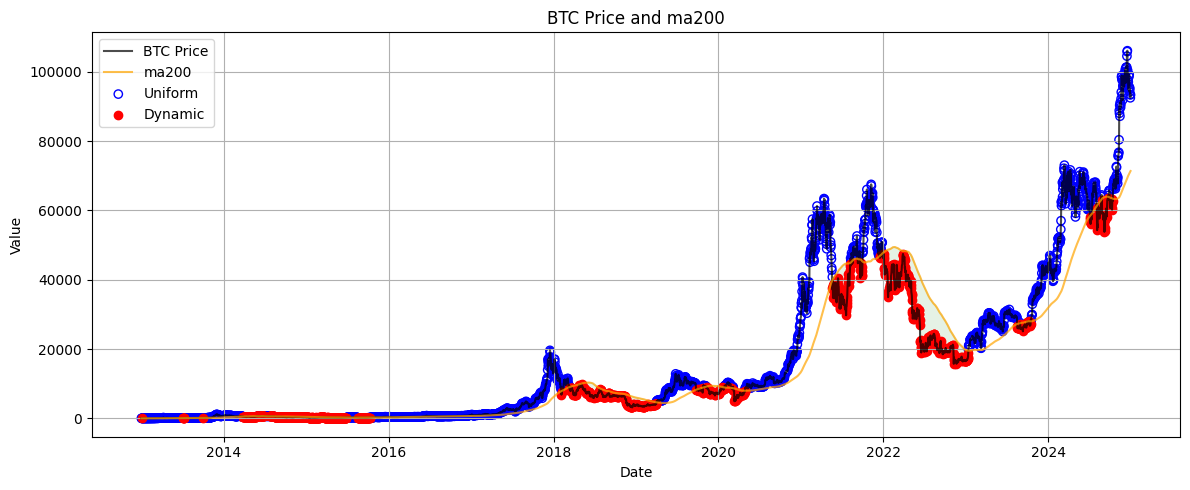

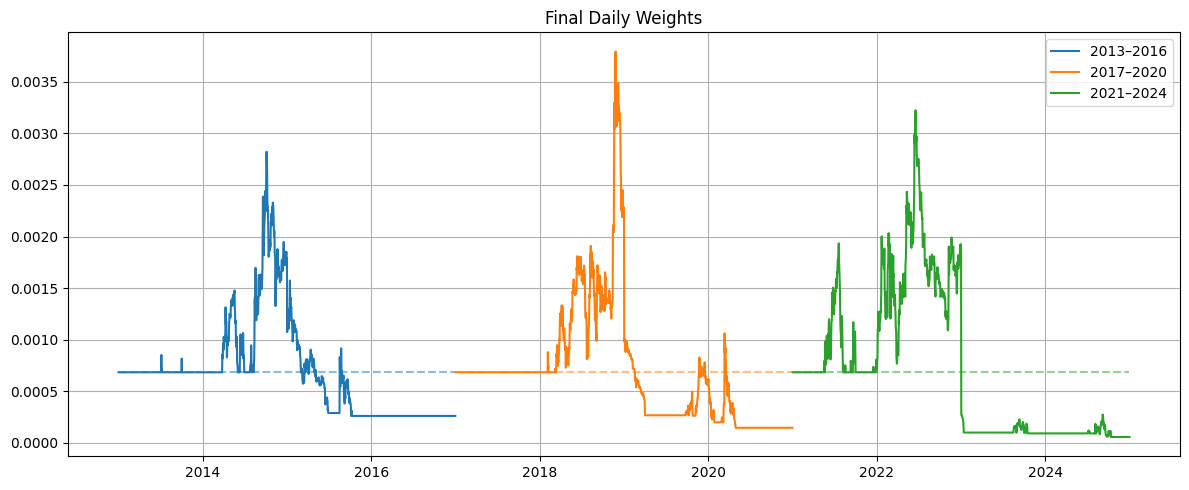

Cycle Weight Sums:
  2013–2016: 1.0000
  2017–2020: 1.0000
  2021–2024: 1.0000


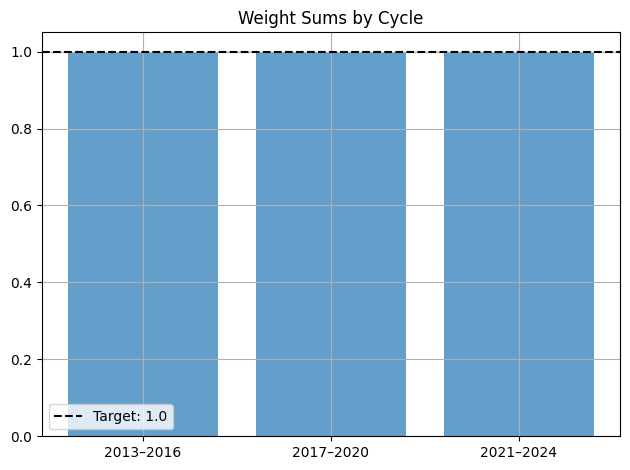


Aggregated Metrics for compute_weights:
Dynamic SPD:
  min: 3494.10
  max: 596638.32
  mean: 208376.24
  median: 24996.29
Dynamic SPD Percentile:
  min: 6.83
  max: 47.22
  mean: 23.84
  median: 17.46

Excess SPD Percentile Difference (Dynamic - Uniform) per Cycle:
  2013–2016: 0.14%
  2017–2020: 1.96%
  2021–2024: 11.86%
✅ Strategy is ready for submission.


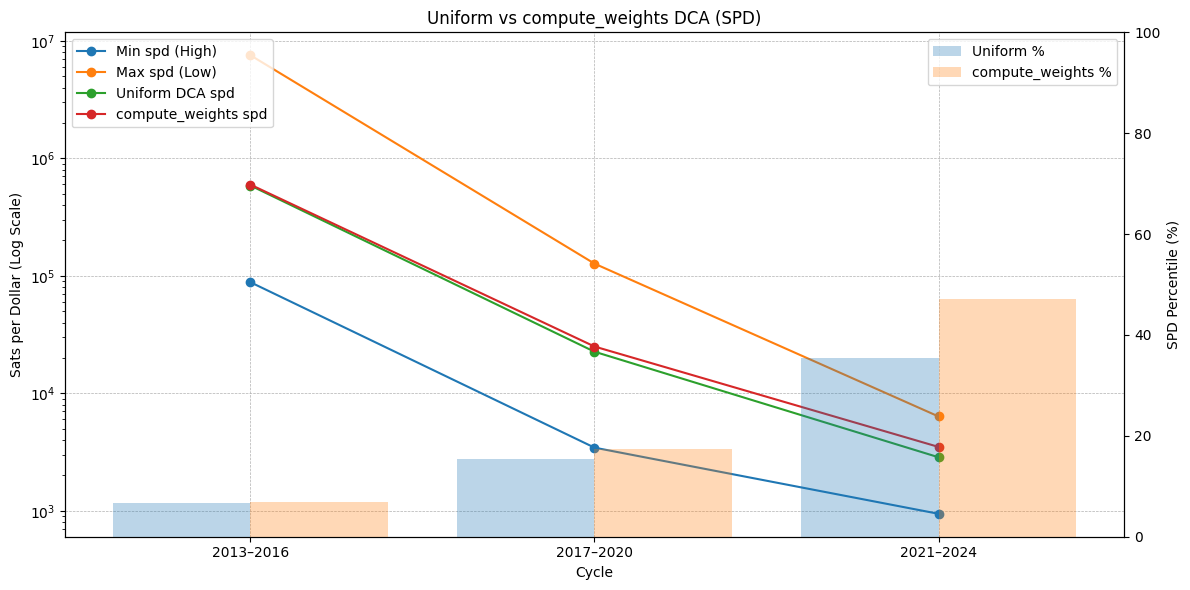

In [12]:
btc_df = load_data()
validate_price_data(btc_df)
btc_df = btc_df.loc[BACKTEST_START:BACKTEST_END]

weights = compute_weights(btc_df)

plot_features(btc_df, weights)
plot_final_weights(weights)
plot_weight_sums_by_cycle(weights)

df_spd = backtest_dynamic_dca(btc_df, strategy_fn=compute_weights, strategy_label="compute_weights")
check_strategy_submission_ready(btc_df, strategy_fn=compute_weights)
plot_spd_comparison(df_spd, strategy_name="compute_weights")